[ref](https://github.com/XifengGuo/DEC-keras/blob/2438070110b17b4fb9bc408c11d776fc1bd1bd56/DEC.py)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from time import time
import numpy as np
import keras.backend as K
# from keras.engine.topology import Layer, InputSpec
from tensorflow.keras.layers import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
# import metrics

In [ ]:
import numpy as np
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score

def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    # from sklearn.utils.linear_assignment_ import linear_assignment
    from scipy.optimize import linear_sum_assignment as linear_assignment
    ind = linear_assignment(w.max() - w)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    x = Input(shape=(dims[0],), name='input')
    h = x

    # internal layers in encoder
    for i in range(n_stacks-1):
        h = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(h)

    # hidden layer
    h = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(h)  # hidden layer, features are extracted from here

    y = h
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        y = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(y)

    # output
    y = Dense(dims[0], kernel_initializer=init, name='decoder_0')(y)

    return Model(inputs=x, outputs=y, name='AE'), Model(inputs=x, outputs=h, name='encoder')

class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.
    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
                 q_ij = 1/(1+dist(x_i, u_j)^2), then normalize it.
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class DEC(object):
    def __init__(self,
                 dims,
                 n_clusters=10,
                 alpha=1.0,
                 init='glorot_uniform'):

        super(DEC, self).__init__()

        self.dims = dims
        self.input_dim = dims[0]
        self.n_stacks = len(self.dims) - 1

        self.n_clusters = n_clusters
        self.alpha = alpha
        self.autoencoder, self.encoder = autoencoder(self.dims, init=init)

        # prepare DEC model
        clustering_layer = ClusteringLayer(self.n_clusters, name='clustering')(self.encoder.output)
        self.model = Model(inputs=self.encoder.input, outputs=clustering_layer)

    def pretrain(self, x, y=None, optimizer='adam', epochs=200, batch_size=256, save_dir='results/temp'):
        print('...Pretraining...')
        self.autoencoder.compile(optimizer=optimizer, loss='mse')

        csv_logger = callbacks.CSVLogger(save_dir + '/pretrain_log.csv')
        cb = [csv_logger]
        if y is not None:
            class PrintACC(callbacks.Callback):
                def __init__(self, x, y):
                    self.x = x
                    self.y = y
                    super(PrintACC, self).__init__()

                def on_epoch_end(self, epoch, logs=None):
                    if int(epochs/10) != 0 and epoch % int(epochs/10) != 0:
                        return
                    feature_model = Model(self.model.input,
                                          self.model.get_layer(
                                              'encoder_%d' % (int(len(self.model.layers) / 2) - 1)).output)
                    features = feature_model.predict(self.x)
                    km = KMeans(n_clusters=len(np.unique(self.y)), n_init=20)
                    y_pred = km.fit_predict(features)
                    # print()
                    print(' '*8 + '|==>  acc: %.4f,  nmi: %.4f  <==|'
                          % (acc(self.y, y_pred), nmi(self.y, y_pred)))

            cb.append(PrintACC(x, y))

        # begin pretraining
        t0 = time()
        self.autoencoder.fit(x, x, batch_size=batch_size, epochs=epochs, callbacks=cb)
        print('Pretraining time: %ds' % round(time() - t0))
        self.autoencoder.save_weights(save_dir + '/ae_weights.h5')
        print('Pretrained weights are saved to %s/ae_weights.h5' % save_dir)
        self.pretrained = True

    def load_weights(self, weights):  # load weights of DEC model
        self.model.load_weights(weights)

    def extract_features(self, x):
        return self.encoder.predict(x)

    def predict(self, x):  # predict cluster labels using the output of clustering layer
        q = self.model.predict(x, verbose=0)
        return q.argmax(1)

    @staticmethod
    def target_distribution(q):
        weight = q ** 2 / q.sum(0)
        return (weight.T / weight.sum(1)).T

    def compile(self, optimizer='sgd', loss='kld'):
        self.model.compile(optimizer=optimizer, loss=loss)

    def fit(self, x, y=None, maxiter=2e4, batch_size=256, tol=1e-3,
            update_interval=140, save_dir='./results/temp'):

        print('Update interval', update_interval)
        # save_interval = int(x.shape[0] / batch_size) * 5  # 5 epochs
        save_interval = 50
        print('Save interval', save_interval)

        # Step 1: initialize cluster centers using k-means
        t1 = time()
        print('Initializing cluster centers with k-means.')
        kmeans = KMeans(n_clusters=self.n_clusters, n_init=20)
        y_pred = kmeans.fit_predict(self.encoder.predict(x))
        y_pred_last = np.copy(y_pred)
        self.model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

        # Step 2: deep clustering
        # logging file
        import csv
        logfile = open(save_dir + '/dec_log.csv', 'w')
        logwriter = csv.DictWriter(logfile, fieldnames=['iter', 'acc', 'nmi', 'ari', 'loss'])
        logwriter.writeheader()

        loss = 0
        index = 0
        index_array = np.arange(x.shape[0])
        for ite in range(int(maxiter)):
            if ite % update_interval == 0:
                q = self.model.predict(x, verbose=0)
                p = self.target_distribution(q)  # update the auxiliary target distribution p

                # evaluate the clustering performance
                y_pred = q.argmax(1)
                if y is not None:
                    acc1 = np.round(acc(y, y_pred), 5)
                    nmi1 = np.round(nmi(y, y_pred), 5)
                    ari1 = np.round(ari(y, y_pred), 5)
                    loss1 = np.round(loss, 5)
                    logdict = dict(iter=ite, acc=acc1, nmi=nmi1, ari=ari1, loss=loss1)
                    logwriter.writerow(logdict)
                    print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc1, nmi1, ari1), ' ; loss=', loss1)

                # check stop criterion
                delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
                print('delta_label ', delta_label)
                y_pred_last = np.copy(y_pred)
                if ite > 200: #and delta_label < tol:
                    print('delta_label ', delta_label, '< tol ', tol)
                    print('Reached tolerance threshold. Stopping training.')
                    logfile.close()
                    break

            # train on batch
            # if index == 0:
            #     np.random.shuffle(index_array)
            idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
            loss = self.model.train_on_batch(x=x[idx], y=p[idx])
            index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

            # save intermediate model
            if ite % save_interval == 0:
                print('saving model to:', save_dir + '/DEC_model_' + str(ite) + '.h5')
                self.model.save_weights(save_dir + '/DEC_model_' + str(ite) + '.h5')

            ite += 1

        # save the trained model
        logfile.close()
        print('saving model to:', save_dir + '/DEC_model_final.h5')
        self.model.save_weights(save_dir + '/DEC_model_final.h5')

        return y_pred

In [ ]:
from PIL import Image
import numpy as np
import os

In [ ]:
# ## COUNT number of files in a dir

# import os

# dir_path = r'/content/drive/MyDrive/Jianwu-Wang-Seraj-Mostafa/Papers by Seraj/2022 GW - DEC 2022/upper-atmospheric-128/skybased-128-pretrain/gw'
# print(len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))

In [ ]:
def loadFiles(path):
  trainImages = []
  arr_all = np.zeros((150,128, 128))
  i = 0
  for r, d, f in os.walk(path):
    for file in f:
       filepath = os.path.join(r, file)
       im = Image.open(filepath)
       arr_all[i,:,:]= np.array(im)
       i+=1
  return arr_all

In [ ]:
train_gw = loadFiles('/content/drive/MyDriveSeraj/upper-atmospheric-128/skybased-128-pretrain/gw')
train_ngw = loadFiles('/content/drive/MyDrive/Seraj/upper-atmospheric-128/skybased-128-pretrain/ngw')

In [ ]:
x_train_gw = train_gw.reshape(train_gw.shape[0], -1)
print(x_train_gw.shape)

x_train_ngw = train_ngw.reshape(train_ngw.shape[0], -1)
print(x_train_ngw.shape)

(150, 16384)
(150, 16384)


In [ ]:
y_train_gw = np.zeros(150)
print(y_train_gw.shape)

y_train_ngw = np.ones(150)
print(y_train_ngw.shape)

(150,)
(150,)


In [ ]:
# x_train_gw

In [ ]:
x_train = np.concatenate((x_train_gw, x_train_ngw), axis=0)
y_train = np.concatenate((y_train_gw, y_train_ngw), axis=0)

In [ ]:
print(x_train.shape)
y_train.shape

(300, 16384)


(300,)

In [ ]:
def main():
    # setting the hyper parameters
    batch_size=64
    maxiter = 2e4
    pretrain_epochs = 2
    update_interval = 10
    tol = 0.0000001
    ae_weights=None
    save_dir = '/content/drive/MyDrive/Seraj/DEC-keras/result' 

    x = x_train
    #y = [0, 1]
    y = y_train #none
    n_clusters = len(np.unique(y))
    # n_clusters = 2

    init = 'glorot_uniform'
    init = VarianceScaling(scale=1. / 3., mode='fan_in',
                               distribution='uniform')  # [-limit, limit], limit=sqrt(1./fan_in)
    pretrain_optimizer = 'adam'
    
    
    # prepare the DEC model
    dec = DEC(dims=[x.shape[-1], 5000, 5000, 10000, 200], n_clusters=n_clusters, init=init)
    #dec.load_weights('.h5 file location')

    if ae_weights is None:
        dec.pretrain(x=x, y=y, optimizer=pretrain_optimizer,
                     epochs=pretrain_epochs, batch_size=batch_size,
                     save_dir=save_dir)
    else:
        dec.autoencoder.load_weights(ae_weights)

    dec.model.summary()
    t0 = time()
    dec.compile(optimizer=SGD(0.0001, 0.9), loss='binary_crossentropy') #, #SGD(0.0001, 0.9)
    y_pred = dec.fit(x, y=y, tol=tol, maxiter=maxiter, batch_size=batch_size,
                     update_interval=update_interval, save_dir=save_dir)
    print('acc:', acc(y, y_pred))
    # y_pred = dec.predict(x)
    print('clustering time: ', (time() - t0))

    return y_pred, 

In [ ]:
result = main()

...Pretraining...
Epoch 1/2
10/10 [==============================] - 3s 276ms/step
        |==>  acc: 0.4333,  nmi: 0.0756  <==|
5/5 [==============================] - 24s 4s/step - loss: 14237769728.0000
Epoch 2/2
10/10 [==============================] - 3s 272ms/step
        |==>  acc: 0.4333,  nmi: 0.0756  <==|
5/5 [==============================] - 23s 5s/step - loss: 159759.1250
Pretraining time: 47s
Pretrained weights are saved to /content/drive/MyDrive/Jianwu-Wang-Seraj-Mostafa/Papers by Seraj/2022 GW - DEC 2022/DEC-keras/result/ae_weights.h5
Model: "model_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 16384)]           0         
                                                                 
 encoder_0 (Dense)           (None, 5000)              81925000  
                                                                 
 encoder_1 (Dense)           (

In [ ]:
result

(array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
        0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
        0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 

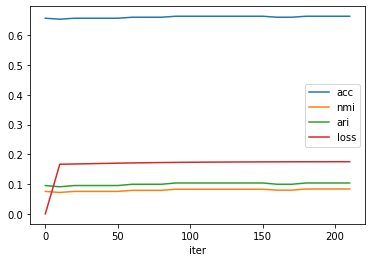

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('/content/drive/MyDrive/Jianwu-Wang-Seraj-Mostafa/Papers by Seraj/2022 GW - DEC 2022/DEC-keras/result/dec_log.csv')
df.plot(x="iter", y=["acc", "nmi", "ari", "loss"], kind="line")